In [1]:
# for EDA
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# for prediction models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from xgboost import XGBRegressor

from sklearn.model_selection import train_test_split
#from sklearn.preprocessing import MinMaxScaler
#from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.callbacks import EarlyStopping
# Evaluation metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error

# plt.style.use("fivethirtyeight")
pal = sns.color_palette()
pal_list = list(pal)

# for image study
import datetime as dt
import os



/voc/work/.local/lib/python3.10/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
2024-11-21 07:16:53.273662: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-21 07:16:55.654929: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-21 07:16:56.385490: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-21 07:16:56.

### Import Dataset

In [2]:
#Load the dataset
items = pd.read_csv('items.csv')
restaurants = pd.read_csv('resturants.csv')
sales = pd.read_csv('sales.csv')

### Examine the datasets

In [3]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109600 entries, 0 to 109599
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   date        109600 non-null  object 
 1   item_id     109600 non-null  int64  
 2   price       109600 non-null  float64
 3   item_count  109600 non-null  float64
dtypes: float64(2), int64(1), object(1)
memory usage: 3.3+ MB


In [4]:
sales.date = pd.to_datetime(sales.date)

In [5]:
items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        100 non-null    int64  
 1   store_id  100 non-null    int64  
 2   name      100 non-null    object 
 3   kcal      100 non-null    int64  
 4   cost      100 non-null    float64
dtypes: float64(1), int64(3), object(1)
memory usage: 4.0+ KB


In [6]:
restaurants.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6 entries, 0 to 5
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      6 non-null      int64 
 1   name    6 non-null      object
dtypes: int64(1), object(1)
memory usage: 224.0+ bytes


### Merge data to create a single data with date, item id, price, item count, item names, kcal values, store id, and store name.


From a data professional's perspective, merging these datasets, which include columns like `date`, `item_id`, `price`, `item_count`, `item name`, `kcal`, `store_id`, and `store name`, provides a comprehensive view of each sale along with product and store details. This enables deeper insights into customer preferences, product demand, and store performance. Having all relevant data in one place allows for accurate, holistic analysis, essential for making informed business decisions, optimizing inventory, and identifying trends across different store locations.

In [7]:
# Preview of sales data to understand available columns and sample data
sales.head(2)

,date,item_id,price,item_count
0,2019-01-01,3,29.22,2.0
1,2019-01-01,4,26.42,22.0


In [8]:
# Preview of items data to see item details that will be merged
items.head(2)

,id,store_id,name,kcal,cost
0,1,4,Chocolate Cake,554,6.71
1,2,4,Breaded Fish with Vegetables Meal,772,15.09


In [9]:
# Check the shape of sales data to understand the number of rows
sales.shape

(109600, 4)

In [10]:
# Step 1: Merge sales with items to bring in item details for each sale
# Here, we use 'item_id' from sales to match with 'id' from items
# The 'how="left"' argument ensures we keep all sales records, even if no match in items
merged_data = pd.merge(sales, items, left_on = "item_id", right_on = "id", how = "left")

In [11]:
restaurants

,id,name
0,1,Bob's Diner
1,2,Beachfront Bar
2,3,Sweet Shack
3,4,Fou Cher
4,5,Corner Cafe
5,6,Surfs Up


In [12]:
merged_data.head(2)

,date,item_id,price,item_count,id,store_id,name,kcal,cost
0,2019-01-01,3,29.22,2.0,3,1,Sweet Fruity Cake,931,29.22
1,2019-01-01,4,26.42,22.0,4,1,Amazing Steak Dinner with Rolls,763,26.42


In [13]:
# Step 2: Merge the result with restaurants data to add store details
# Here, 'store_id' from the sales-items merged data is matched with 'id' in restaurants
# This helps in adding store names to the dataset for a more complete view of each sale
data = pd.merge(merged_data, restaurants, left_on = 'store_id', right_on = 'id')

In [14]:
# Verify the first few rows of the final merged data to confirm successful merging
data.head(2)  # Preview the final merged data to confirm it has desired columns and data

,date,item_id,price,item_count,id_x,store_id,name_x,kcal,cost,id_y,name_y
0,2019-01-01,3,29.22,2.0,3,1,Sweet Fruity Cake,931,29.22,1,Bob's Diner
1,2019-01-01,4,26.42,22.0,4,1,Amazing Steak Dinner with Rolls,763,26.42,1,Bob's Diner


In [15]:
# Check for consistency by confirming all item_id values in sales match with id_x from items
(data.item_id == data.id_x).all()

True

In [16]:
# Similarly, verify all store_id values in sales match with id_y from restaurants
(data.store_id == data.id_y).all()

True

### Rename the columns for easier understanding and drop the duplicate columns

In [17]:
# Rename columns to make them more descriptive and intuitive
# "name_x" (from items) is renamed to "item_name" for clarity
# "name_y" (from restaurants) is renamed to "restaurant_name"
data.rename(columns = {"name_x" : "item_name", "name_y": "restaurant_name"}, inplace = True)

In [18]:
# Drop unnecessary columns that are no longer needed in the final dataset
# 'id_x' and 'id_y' were used for merging but are redundant now
# 'cost' may be excluded if it is not needed for the final analysis
data.drop(columns = ['id_x', 'id_y', 'cost'], inplace = True)

In [19]:
data.head(2)

,date,item_id,price,item_count,store_id,item_name,kcal,restaurant_name
0,2019-01-01,3,29.22,2.0,1,Sweet Fruity Cake,931,Bob's Diner
1,2019-01-01,4,26.42,22.0,1,Amazing Steak Dinner with Rolls,763,Bob's Diner


## **EDA Process**

We will perform EDA from a global level to a store and store-specific-item level. Here are the questions we will answer:

1. What is the overall sales trend on a daily basis?
2. How does sales volume vary across different days of the week?
3. Are there noticeable trends in the sales data for different months of the year?
4. How is sales distributed across quarters, and are there any notable patterns when averaged over years?
5. How do quarterly sales fluctuate over time?
6. Which restaurant has the highest sales overall?
7. How does sales vary for each restaurant across different years, months, and days?
8. How do daily sales trends vary for each store individually?
9. What are the sales trends for each store on a quarterly basis over multiple years?
10. How does each store perform in terms of monthly sales?
11. How does each store’s sales vary by day of the week?
12. What are the most popular items across all stores, and in which stores are they sold?
13. What is the most popular item at each individual store?
14. Is the store with the highest sales volume also generating the most revenue on a daily basis?
15. What is the most expensive item at each restaurant, and what is its calorie count?
16. What are the maximum, minimum, and average prices of items sold at each restaurant?



### Study overall sales date-wise to understand the sales pattern.

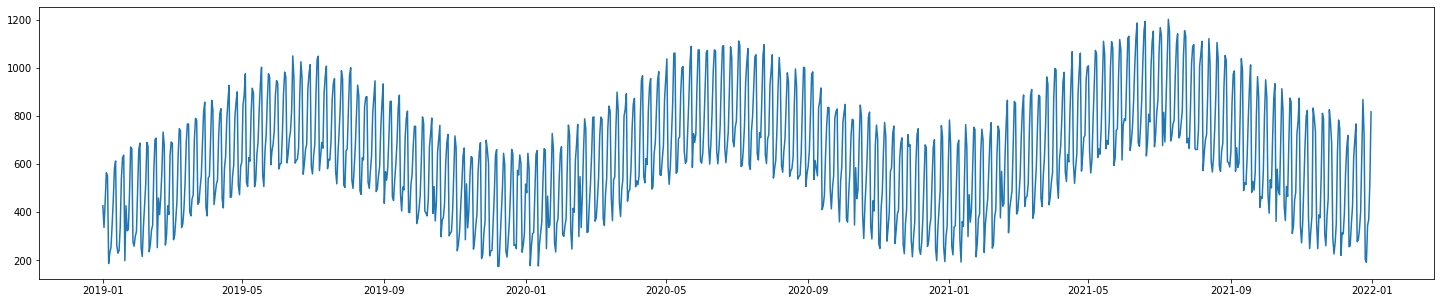

In [20]:
grpd = sales.groupby(['date'])[['item_count']].sum()
plt.figure(figsize = (25,5))
plt.plot(grpd)
plt.show()

Sales show a varying pattern over time when analyzed on a daily basis, helping identify peak and low sales dates.

### Find out how the sales fluctuate across different days of the week?

In [21]:
data['weekday'] = data.date.dt.day_name()

In [22]:
import calendar
day_names = list(calendar.day_name)

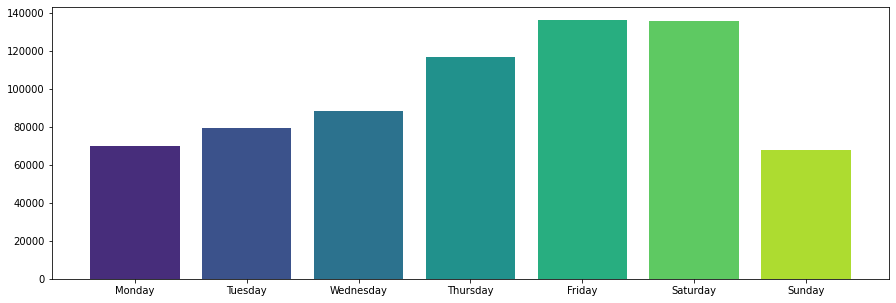

In [23]:
grpd = data.groupby(['weekday'])[['item_count']].sum()
grpd = grpd.loc[day_names].squeeze()

# Define your color palette, e.g., using seaborn or a simple list of colors
pal = sns.color_palette("viridis", len(grpd))  # or use any other color palette

plt.figure(figsize=(15, 5))
plt.bar(grpd.index, grpd.values, color=pal)
plt.show()

Sales fluctuate across different days of the week, with specific days exhibiting higher or lower sales volumes. This insight is essential for planning inventory and staffing. Here the sales are higher for Fridays and Saturdays.

### Look for any noticeable trends in the sales data for different months of the year.

In [24]:
data['month_name'] = data.date.dt.month_name()

In [25]:
months = list(calendar.month_name)[1:]

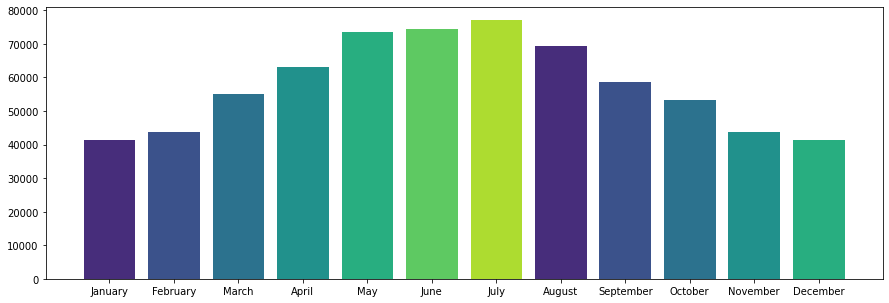

In [26]:
grpd = data.groupby(['month_name'])[['item_count']].sum()
grpd = grpd.loc[months].squeeze()
plt.figure(figsize = (15,5))
plt.bar(height = grpd.values, x = grpd.index, color = pal)
plt.show()

Sales patterns differ by month, showing seasonal trends that may be influenced by holidays, seasonal promotions, or customer behavior. Here the sales of july month is highest.


### Examine the distribution of sales across different quarters averaged over years. Identify any noticeable pattern in sales.


In [27]:
data['quarter'] = data.date.dt.quarter

In [28]:
data

,date,item_id,price,item_count,store_id,item_name,kcal,restaurant_name,weekday,month_name,quarter
0,2019-01-01,3,29.22,2.0,1,Sweet Fruity Cake,931,Bob's Diner,Tuesday,January,1
1,2019-01-01,4,26.42,22.0,1,Amazing Steak Dinner with Rolls,763,Bob's Diner,Tuesday,January,1
2,2019-01-01,12,4.87,7.0,1,Fantastic Sweet Cola,478,Bob's Diner,Tuesday,January,1
3,2019-01-01,13,4.18,12.0,1,Sweet Frozen Soft Drink,490,Bob's Diner,Tuesday,January,1
4,2019-01-01,16,3.21,136.0,1,Frozen Milky Smoothy,284,Bob's Diner,Tuesday,January,1
...,...,...,...,...,...,...,...,...,...,...,...
109595,2021-12-31,49,1.39,0.0,3,Awesome Smoothy,78,Sweet Shack,Friday,December,4
109596,2021-12-31,52,5.68,0.0,3,Original Sweet Milky Soft Drink,535,Sweet Shack,Friday,December,4
109597,2021-12-31,77,7.70,0.0,3,Blue Ribbon Frozen Milky Cake,636,Sweet Shack,Friday,December,4
109598,2021-12-31,81,5.11,0.0,3,Fantastic Milky Smoothy,383,Sweet Shack,Friday,December,4


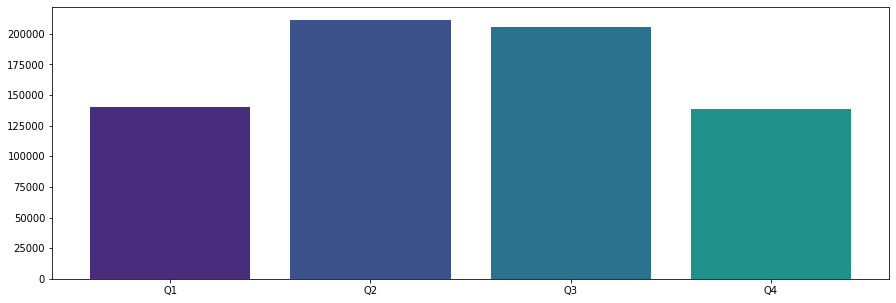

In [29]:
grpd = data.groupby(['quarter'])[['item_count']].sum().squeeze()
plt.figure(figsize = (15,5))
plt.bar(height = grpd.values, x = grpd.index, color = pal)
plt.xticks(range(1,5),["Q"+str(i) for i in range(1,5)])
plt.show()

Sales distributed by quarters reveal quarterly growth trends or declines, allowing for better forecasting and budgeting. Here Q2 gives most number of sales.


In [30]:
data['year'] = data.date.dt.year

In [31]:
data['quart-year'] = "Q" + data.quarter.astype(str) + "-" + data.year.astype(str)

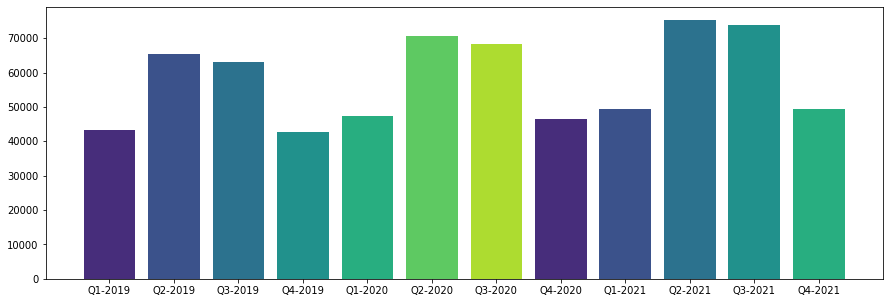

In [32]:
order = ['Q{}-{}'.format(j,i) for i in range(2019, 2022) for j in range(1,5)]
grpd = data.groupby(["quart-year"])[['item_count']].sum()
grpd = grpd.loc[order].squeeze()
plt.figure(figsize = (15,5))
plt.bar(height = grpd.values, x = grpd.index, color = pal)
plt.show()

Tracking quarterly sales across years indicates long-term trends and seasonal cycles, providing insight into the business's year-over-year growth or decline. Here it can be seen that Q2 and Q3 got the highest number of sales year on year.

### Compare the performances of different restaurants.Which restaurant had the most sales? Also study the sales for each restaurant across different years months and days.


In [33]:
data.groupby('store_id')[['item_count']].sum()

,item_count
store_id,
1,687527.0
2,1305.0
3,1736.0
4,1106.0
5,1310.0
6,1803.0


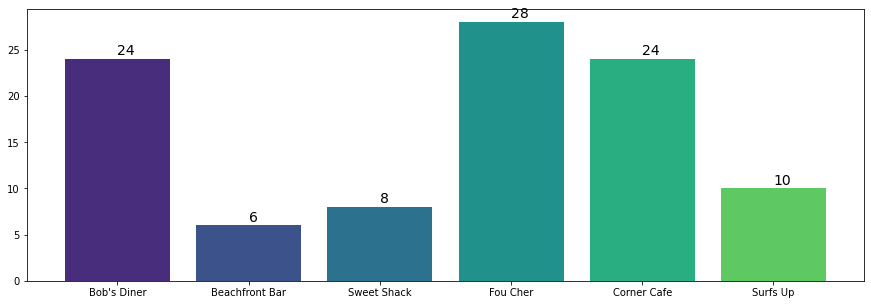

In [34]:
items_served = items.groupby(['store_id']).agg({'id' : "nunique"}).squeeze()
plt.figure(figsize = (15,5))
plt.bar(items_served.index, items_served.values, color = pal)
plt.xticks(range(1,7), restaurants.name)
for i in range(1,7):
  plt.annotate(items_served[i], xy = (i, items_served[i]+0.45), size = 14)

plt.show()

Among the restaurants, some consistently perform better than others. For instance, Fou Cher has the highest sales in both item count and revenue.

### Store wise sales

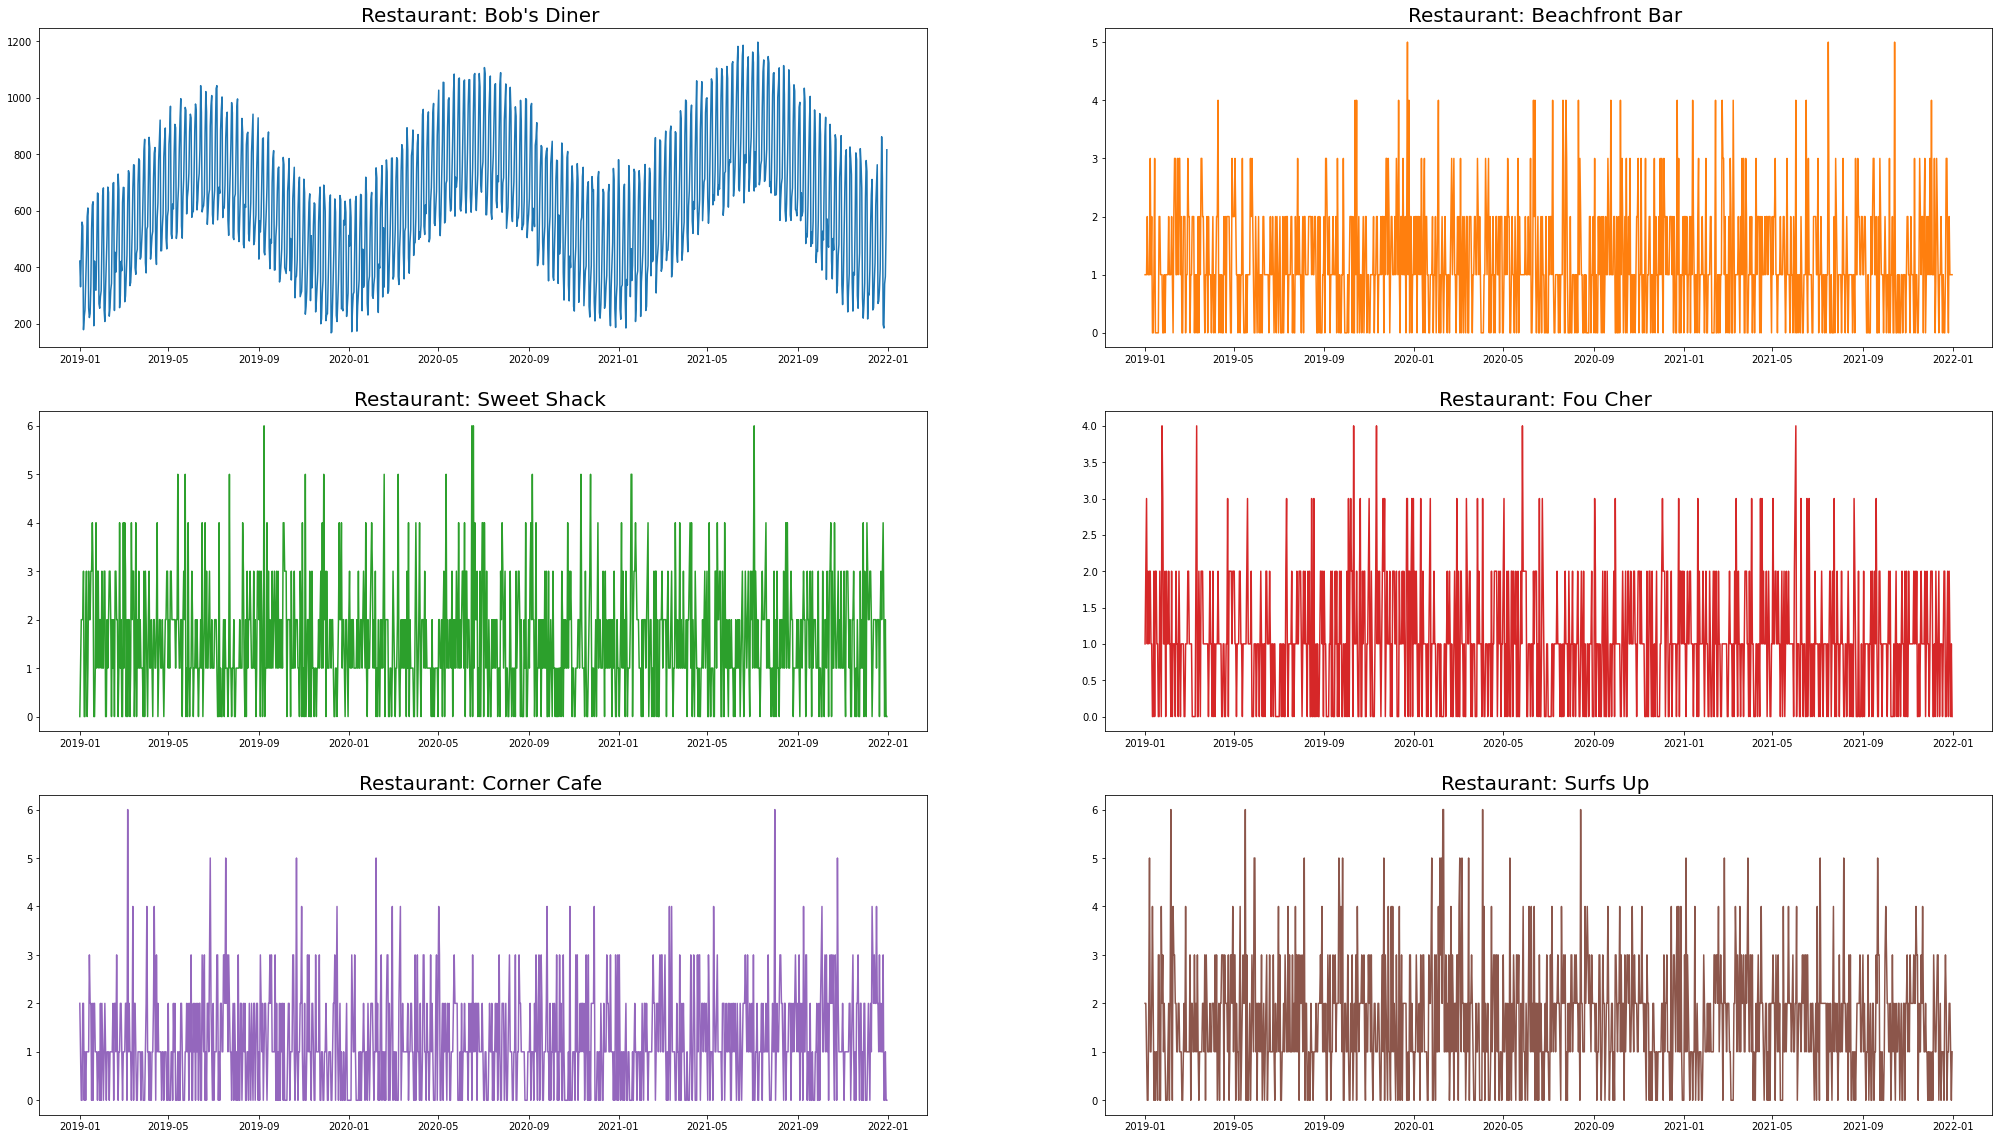

In [35]:
plot_data = data.pivot_table(index = 'date', columns = 'store_id',values = 'item_count', aggfunc = 'sum')
f,ax = plt.subplots(3,2,figsize =(35,20) )
r,c = 0,0
# Define `pal_list` as a list of colors
pal_list = sns.color_palette("tab10", 6)  # generates 6 distinct colors
for i in range(1,7):
  ax[r,c].plot(plot_data.loc[:, i], color = pal_list[i-1])
  ax[r,c].set_title('Restaurant: {} '.format(restaurants.loc[restaurants.id == i, 'name'].values[0]), size = 20)
  c += 1
  if c == 2:
    c = 0
    r +=1


Each store has its unique sales pattern on a daily basis, highlighting differences in customer flow and demand across locations.

### Year wise sales for each store

In [36]:
plot_data = data.pivot_table(index = 'quart-year', columns = 'store_id',values = 'item_count', aggfunc = 'sum')


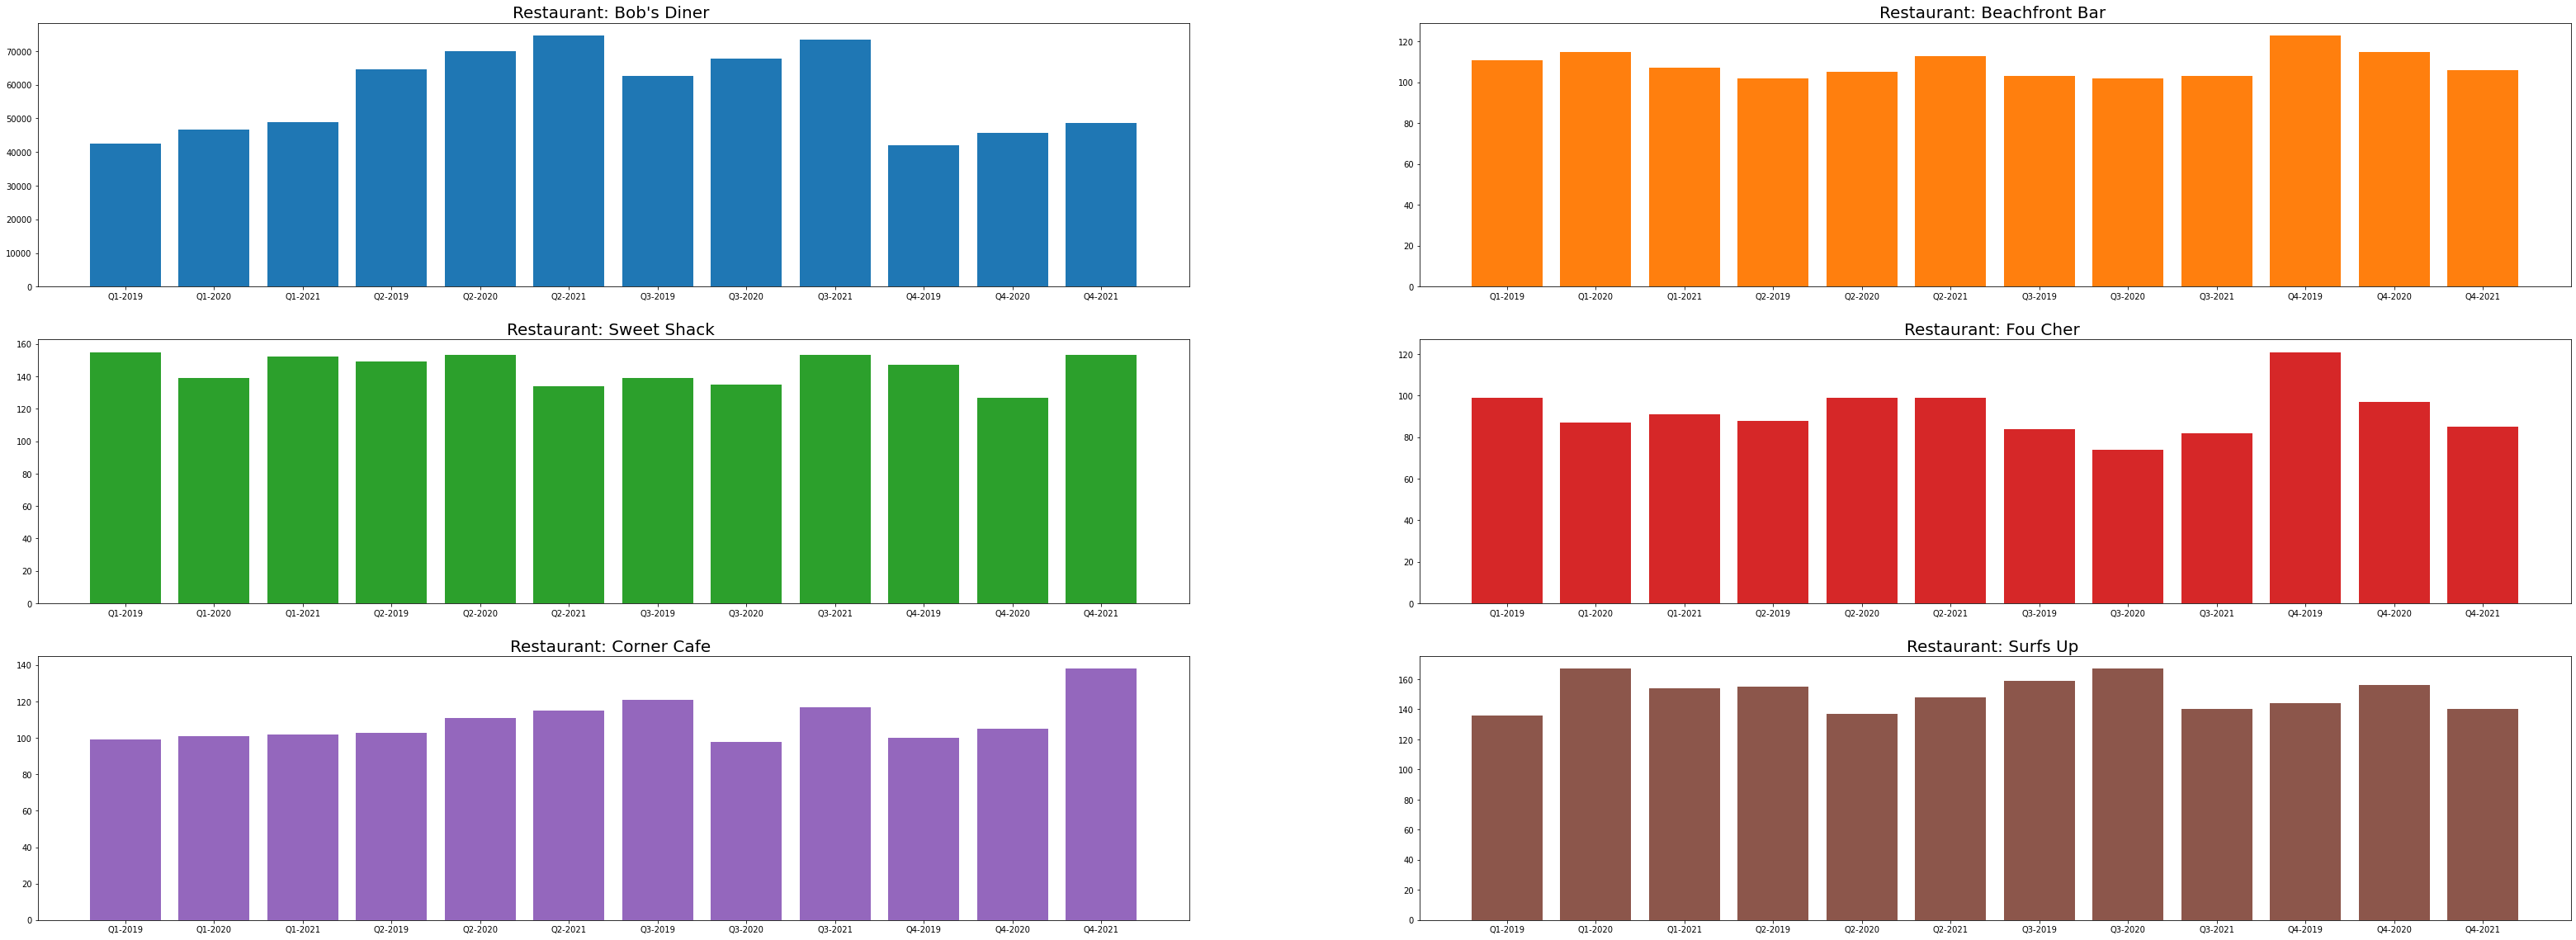

In [37]:
plot_data = data.pivot_table(index = 'quart-year', columns = 'store_id',values = 'item_count', aggfunc = 'sum')
f,ax = plt.subplots(3,2,figsize =(55,20) )
r,c = 0,0
for i in range(1,7):
  ax[r,c].bar(x = plot_data.index,height = plot_data.loc[:, i], color = pal_list[i-1])
  ax[r,c].set_title('Restaurant: {} '.format(restaurants.loc[restaurants.id == i, 'name'].values[0]), size = 20)
  c += 1
  if c == 2:
    c = 0
    r +=1


The analysis of quarterly sales by store over multiple years highlights growth or declining trends specific to each location.

1. Bob's Diner: Peaks in Q2-Q3 each year, with noticeable declines in Q4.
2. Beachfront Bar: Strong performance in Q4 2019, otherwise stable across quarters.
3. Sweet Shack: Consistent sales across all quarters, with minor fluctuations.
4. Fou Cher: Peaks sharply in Q4 2019, with more variable sales across other quarters.
5. Corner Cafe: Mostly stable, with a slight increase in Q4 2021.
6. Surfs Up: Steady sales with a peak in Q1 2020.





### Month wise sales

/tmp/ipykernel_269/2619853384.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[r,c].set_xticklabels(labels = months, fontsize = 20)
/tmp/ipykernel_269/2619853384.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[r,c].set_xticklabels(labels = months, fontsize = 20)
/tmp/ipykernel_269/2619853384.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[r,c].set_xticklabels(labels = months, fontsize = 20)
/tmp/ipykernel_269/2619853384.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[r,c].set_xticklabels(labels = months, fontsize = 20)
/tmp/ipykernel_269/2619853384.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[r,c].set_xticklabels(labels = months, fontsize = 20)
/tmp/ipykernel_269/2619853384.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[r,c].set_xticklabels(labels = months, f

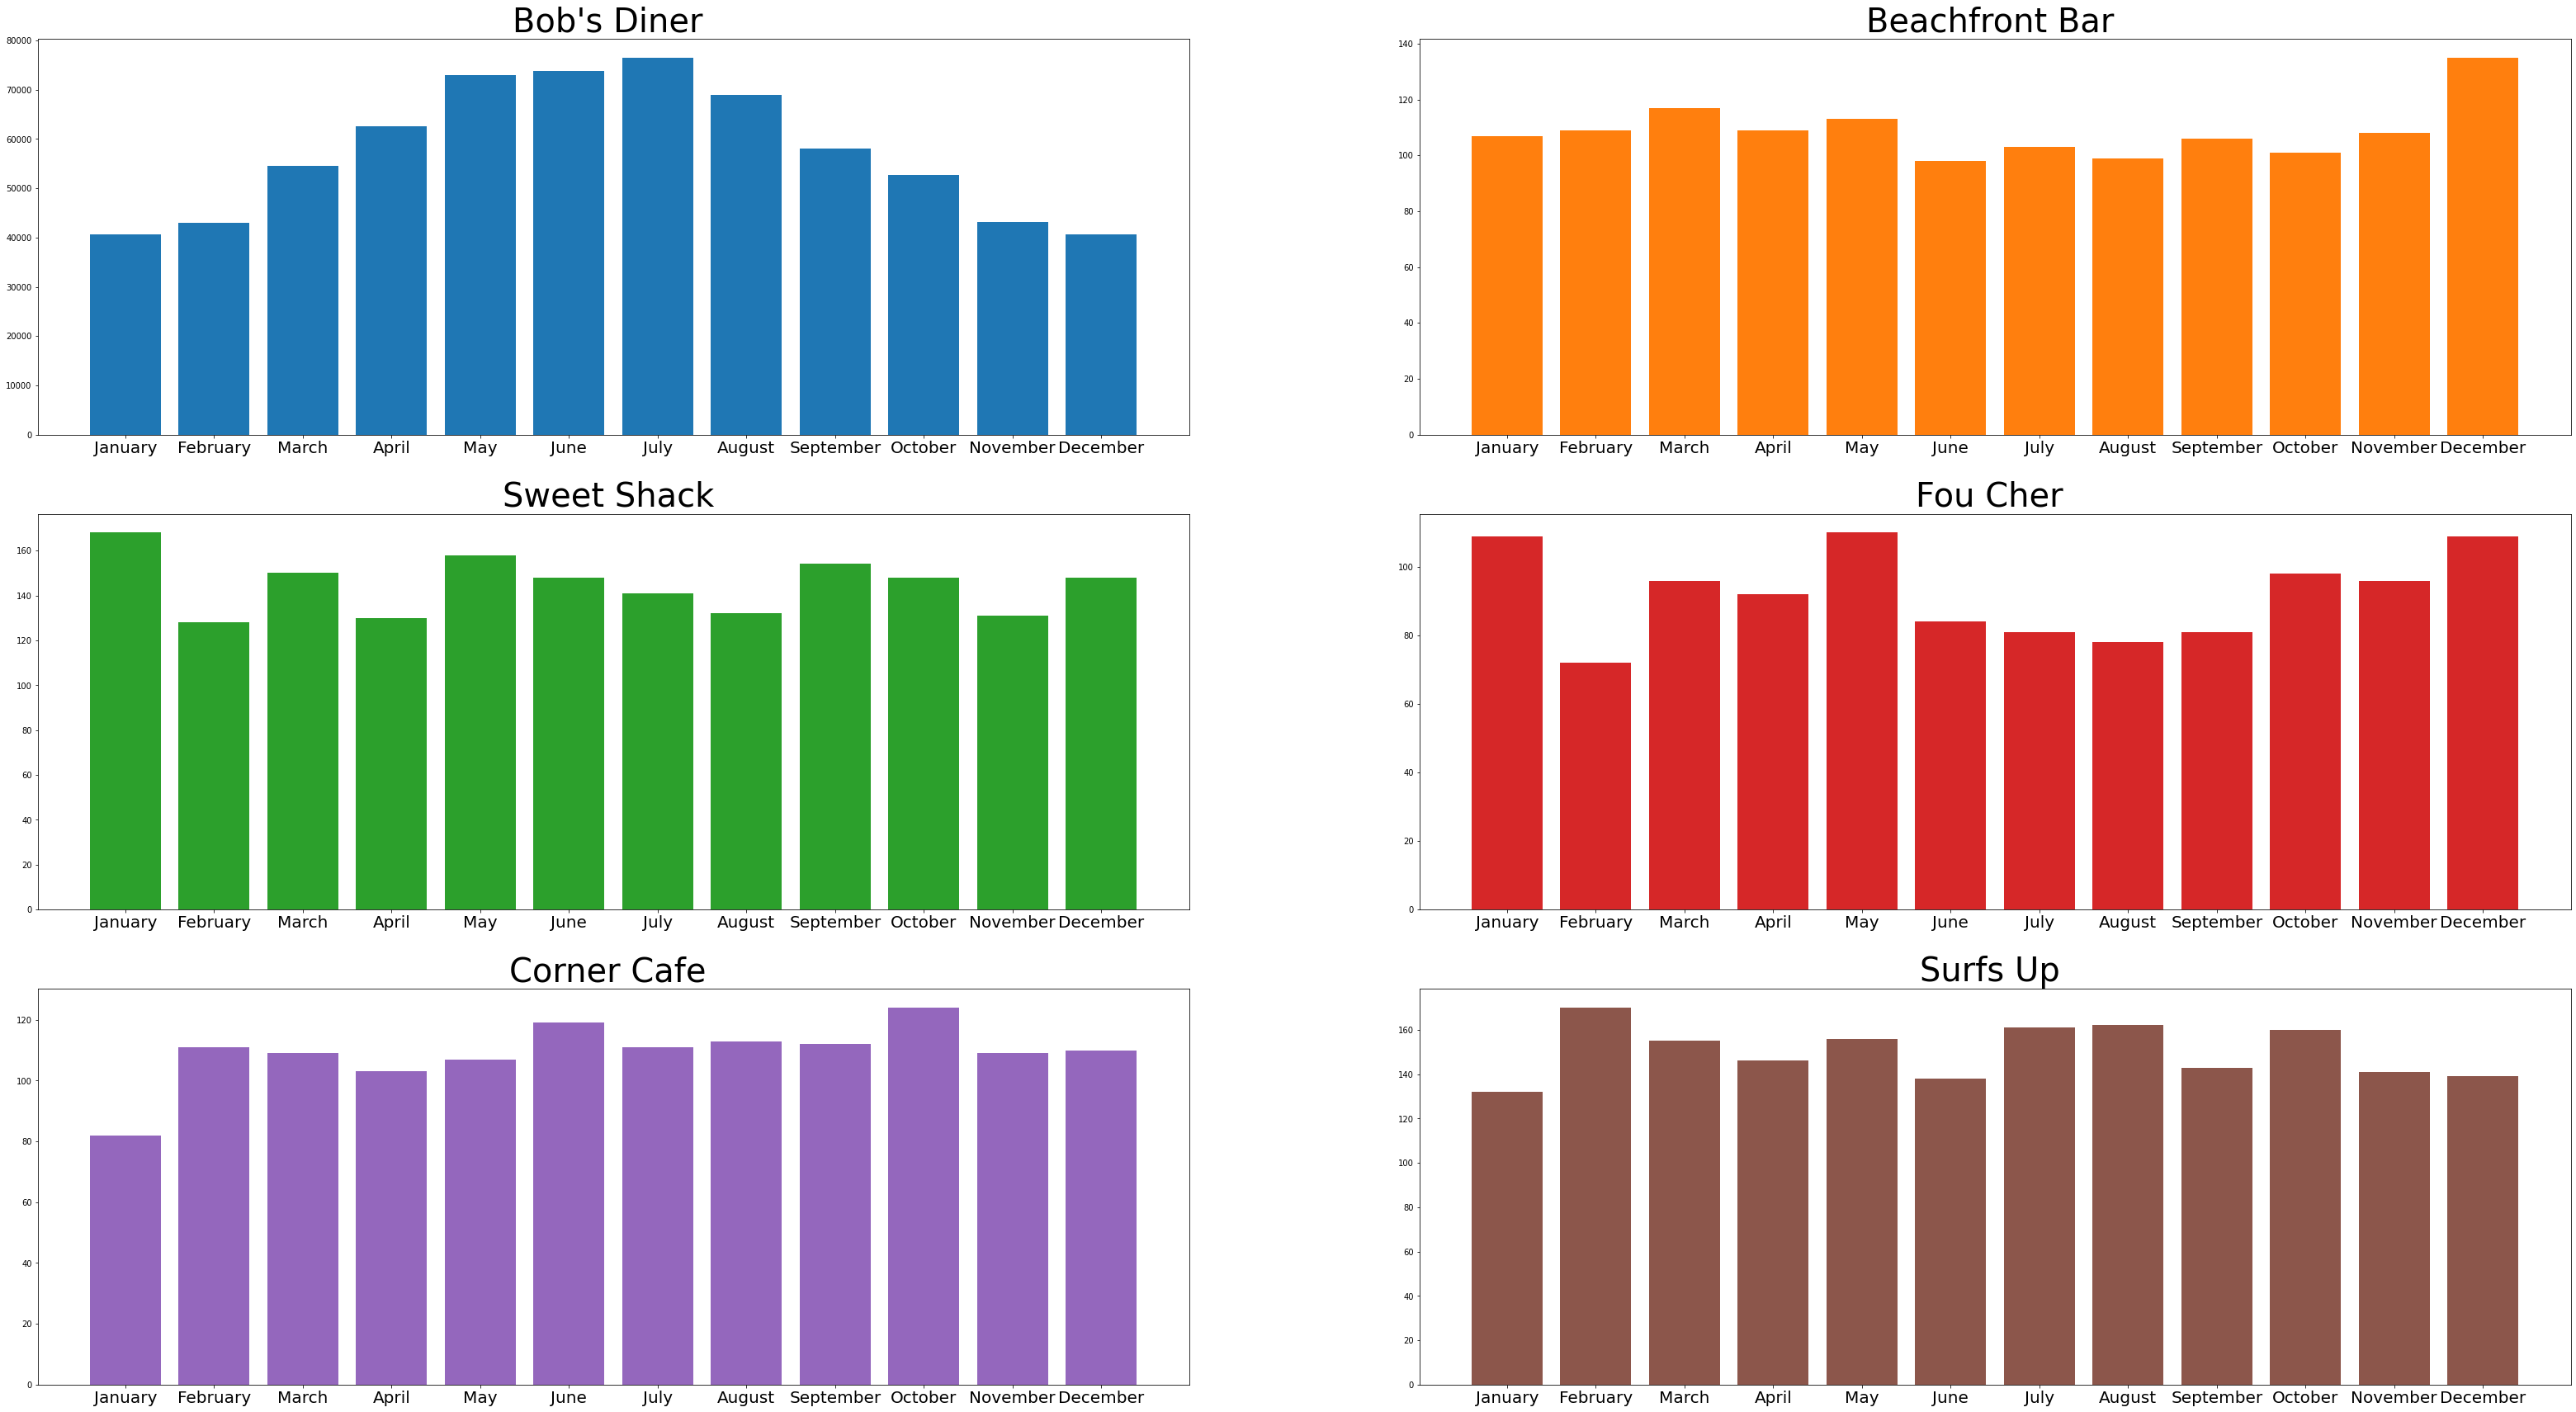

In [38]:
plot_data = data.pivot_table(index = 'month_name', columns = 'store_id',values = 'item_count', aggfunc = 'sum')
plot_data = plot_data.loc[months]
f,ax = plt.subplots(3,2,figsize =(55,30) )
r,c = 0,0
for i in range(1,7):
  ax[r,c].bar(x = plot_data.index,height = plot_data.loc[:, i], color = pal_list[i-1])
  ax[r,c].set_title('{} '.format(restaurants.loc[restaurants.id == i, 'name'].values[0]), size = 40)
  ax[r,c].set_xticklabels(labels = months, fontsize = 20)
  c += 1
  if c == 2:
    c = 0
    r +=1

Sales across months vary significantly for each store, showing monthly trends that are useful for targeted marketing and promotions.

The monthly sales trends show:

1. Bob's Diner: Peaks in summer, declines towards year-end.
2. Beachfront Bar: Steady with a December boost.
3. Sweet Shack: Consistent throughout the year.
4. Fou Cher: Peaks in May, rises again in November-December.
5. Corner Cafe: Stable, with a slight June peak.
6. Surfs Up: Stable with minor early and mid-year peaks.

### Day wise sales

/tmp/ipykernel_269/3239954549.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[r,c].set_xticklabels(labels = day_names, fontsize = 20)
/tmp/ipykernel_269/3239954549.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[r,c].set_xticklabels(labels = day_names, fontsize = 20)
/tmp/ipykernel_269/3239954549.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[r,c].set_xticklabels(labels = day_names, fontsize = 20)
/tmp/ipykernel_269/3239954549.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[r,c].set_xticklabels(labels = day_names, fontsize = 20)
/tmp/ipykernel_269/3239954549.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[r,c].set_xticklabels(labels = day_names, fontsize = 20)
/tmp/ipykernel_269/3239954549.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[r,c].set_xticklabels(lab

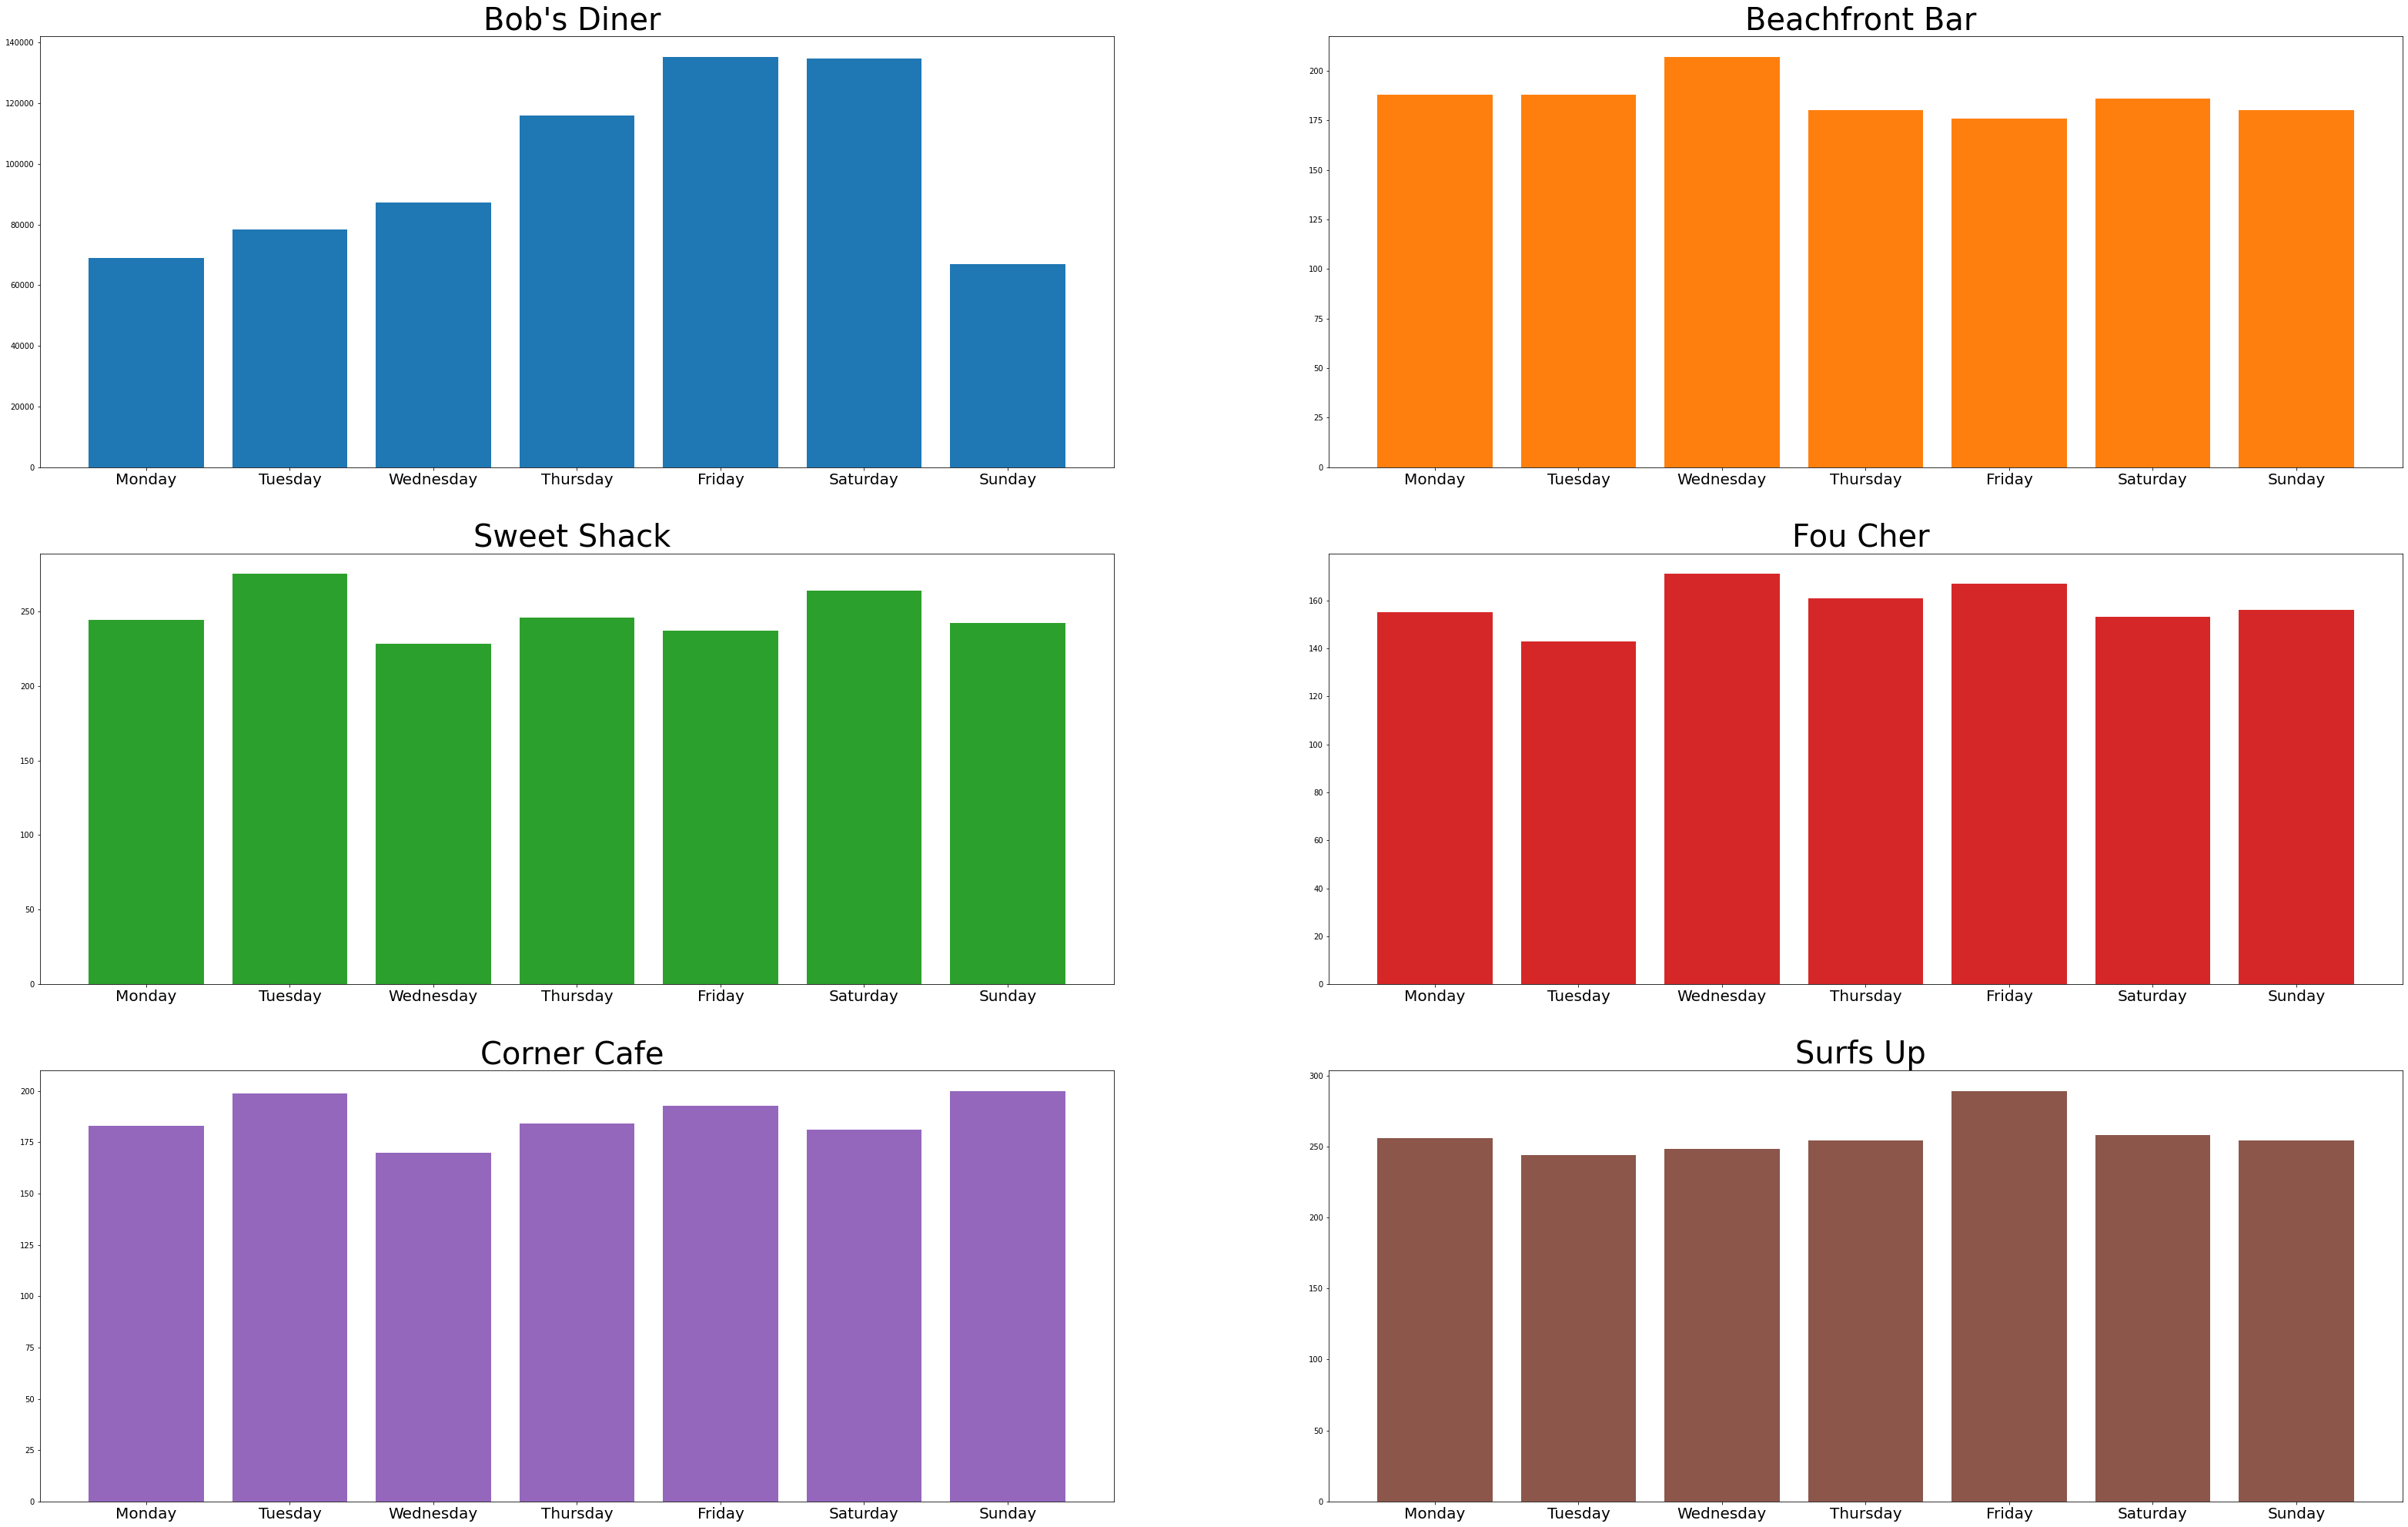

In [39]:
plot_data = data.pivot_table(index = 'weekday', columns = 'store_id',values = 'item_count', aggfunc = 'sum')
plot_data = plot_data.loc[day_names]
f,ax = plt.subplots(3,2,figsize =(55,35) )
r,c = 0,0
for i in range(1,7):
  ax[r,c].bar(x = plot_data.index,height = plot_data.loc[:, i], color = pal_list[i-1])
  ax[r,c].set_title('{} '.format(restaurants.loc[restaurants.id == i, 'name'].values[0]), size = 40)
  ax[r,c].set_xticklabels(labels = day_names, fontsize = 20)
  c += 1
  if c == 2:
    c = 0
    r +=1
plt.show()

Each store has different peak days of the week, which helps in understanding and optimizing operational needs.

1. Bob's Diner: Peaks on Fridays and Saturdays, with a noticeable drop on Sundays.
2. Beachfront Bar: Highest sales on Wednesdays, with consistent sales on other weekdays.
3. Sweet Shack: Steady throughout the week, with slight increases on Tuesdays and Saturdays.
4. Fou Cher: Peaks on Wednesdays, with relatively even sales across other days.
5. Corner Cafe: Consistent across all days, with a slight increase on Mondays and Tuesdays.
6. Surfs Up: Peaks on Fridays

### Identify the most popular items overall and the stores where they are being sold. Also find out the most popular item at the store.


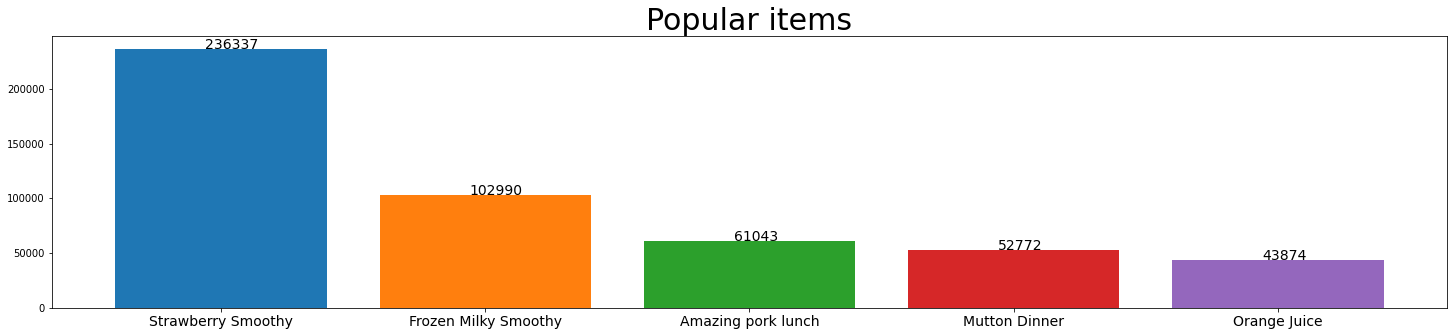

In [40]:
plot_data = data.groupby('item_id')[['item_count']].sum().sort_values('item_count',ascending = False).reset_index()[:5]
final_plot_data = pd.merge(plot_data, items, left_on = 'item_id', right_on = 'id', how = 'left')[['item_id', 'item_count', 'name', 'kcal', 'cost', 'store_id']]
plt.figure(figsize = (25,5))
plt.bar(final_plot_data.name, final_plot_data.item_count, color = pal_list)
plt.title('Popular items', size= 30)
for k in range(5):
  val = final_plot_data.loc[k,'item_count']
  plt.annotate('{:0.0f}'.format(val), xy = (k-0.06, val), size = 14)
plt.xticks(size = 14)
plt.show()

Certain items are universally popular across stores, while each store also has its unique top-sellers. This analysis helps in inventory management and targeted promotions.

Smoothies, especially Strawberry and Frozen Milky, are the top-selling items, indicating high customer preference for these drinks.


In [41]:
count_data = data.pivot_table(index = 'item_id', columns = 'store_id',values = 'item_count', aggfunc = 'sum', fill_value = 0 )
item_ids = count_data.index[count_data.values.argmax(axis = 0)]


### Popular items restaurant wise

In [42]:
pop_items = items.loc[items.id.isin(item_ids), ['store_id', 'id', 'name', 'kcal', 'cost']]
pop_data = pd.merge(pop_items, restaurants, how = 'left', left_on = 'store_id', right_on = 'id', suffixes = ('_item', '_restaurant'))
pop_data['count'] = count_data.loc[item_ids,].sum(axis = 0).reset_index().iloc[:,1]
pop_data = pop_data[['name_restaurant', 'name_item', 'kcal', 'cost', 'count']]
pop_data

,name_restaurant,name_item,kcal,cost,count
0,Bob's Diner,Strawberry Smoothy,145,2.89,236337
1,Beachfront Bar,Fantastic Milky Smoothy,318,2.91,1147
2,Sweet Shack,Awesome Smoothy,78,1.39,1692
3,Corner Cafe,Frozen Milky Smoothy,211,3.98,298
4,Fou Cher,Blue Ribbon Fruity Vegi Lunch,881,53.98,273
5,Surfs Up,Awesome Soft Drink,248,3.06,997


### Determine if the store with the highest sales volume is also making the most money per day.


In [43]:
data.groupby('store_id')[['item_count']].sum().reset_index()

,store_id,item_count
0,1,687527.0
1,2,1305.0
2,3,1736.0
3,4,1106.0
4,5,1310.0
5,6,1803.0


In [44]:
data.pivot_table(index = 'store_id', columns = 'year', values = 'item_count', aggfunc = 'sum')

year,2019,2020,2021
store_id,,,
1,211799.0,230191.0,245537.0
2,439.0,437.0,429.0
3,590.0,554.0,592.0
4,392.0,357.0,357.0
5,423.0,415.0,472.0
6,594.0,627.0,582.0


In [45]:
data['sales_amnt'] = data.item_count * data.price

In [46]:
data.pivot_table(index = 'store_id', columns = 'year', values = 'sales_amnt', aggfunc = 'sum')

year,2019,2020,2021
store_id,,,
1,1849483.49,2112331.91,2375460.29
2,1281.85,1267.21,1247.14
3,872.59,828.65,877.03
4,9698.80,8590.87,9595.70
5,5292.93,5347.71,5910.79
6,5132.65,5314.43,5204.41


In [47]:
count_order = data.pivot_table(index = 'store_id',  values = 'sales_amnt', aggfunc = 'sum').squeeze()
count_order_rest = count_order.sort_values(ascending = False).index

In [48]:
sales_order = data.pivot_table(index = 'store_id',  values = 'item_count', aggfunc = 'sum').squeeze()
sales_order_rest = sales_order.sort_values(ascending = False).index

In [49]:
restaurants

,id,name
0,1,Bob's Diner
1,2,Beachfront Bar
2,3,Sweet Shack
3,4,Fou Cher
4,5,Corner Cafe
5,6,Surfs Up


Since restaurant id 1 i.e Bob's Diner has disproportionate data we will leave it out for this analysis to understand that number and sales values match or not for others or not

In [50]:
count_order

store_id
1    6337275.69
2       3796.20
3       2578.27
4      27885.37
5      16551.43
6      15651.49
Name: sales_amnt, dtype: float64

In [51]:
restaurants.set_index('id').loc[count_order_rest]

,name
store_id,
1,Bob's Diner
4,Fou Cher
5,Corner Cafe
6,Surfs Up
2,Beachfront Bar
3,Sweet Shack


In [52]:
restaurants.set_index('id').loc[sales_order_rest]

,name
store_id,
1,Bob's Diner
6,Surfs Up
3,Sweet Shack
5,Corner Cafe
2,Beachfront Bar
4,Fou Cher


Bob's Diner is highest grossing in numbers as well as sales value.
However Fou Cher which is second highest with respect to numbers on the other hand its making least money out of the 6 restaurants

### Identify the most expensive item at each restaurant and find out its calorie count.

In [53]:
items.iloc[[items.cost.argmax()]]

,id,store_id,name,kcal,cost
79,80,4,Blue Ribbon Fruity Vegi Lunch,881,53.98


In [54]:
items.sort_values("cost",ascending = False)[:5]

,id,store_id,name,kcal,cost
79,80,4,Blue Ribbon Fruity Vegi Lunch,881,53.98
2,3,1,Sweet Fruity Cake,931,29.22
55,56,1,Sea Bass with Vegetables Dinner,613,28.75
96,97,4,Original Fruity Cod with Bread and Vegetables ...,744,28.65
33,34,4,Sweet Savory Cake,721,27.47


Blue Ribbon Fruity Vegi Lunch	is the most expensive item.

###  Max and min cost of items sold at each restaurant

In [55]:
items.groupby('store_id')[['cost']].agg(['max', 'min', 'mean'])

cost                 
            max   min       mean
store_id                        
1         29.22  2.89  12.211667
2          5.70  2.43   3.585000
3          7.70  1.39   5.276250
4         53.98  3.23  12.819643
5         26.37  3.74  13.371667
6         26.21  3.06  13.970000

List of most expensive items sold at each restaurant.

## Develop a linear regression, random forest and XGBoost model to predict for the model with the given data. Compare and comment on the results obtained.
- Create required features for development of these models like day of the week, quarter of the year, month, year, day of the month etc.
- Use the last six months data as test data.
- Compute the RMSE values for each of the models to compare their performances.
- Also use these models to forecast for 1 year.


Linear Regression provides a baseline for straightforward trend analysis, Random Forest adds robustness by capturing more complex interactions, and XGBoost leverages its powerful boosting capabilities to maximize accuracy. Using these three models allows Fresh Analytics to balance interpretability, robustness, and predictive accuracy, aligning well with the goal of making data-driven, reliable business decisions.

In [56]:
data.date.describe()

/tmp/ipykernel_269/3984613233.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  data.date.describe()


count                  109600
unique                   1096
top       2021-12-31 00:00:00
freq                      100
first     2019-01-01 00:00:00
last      2021-12-31 00:00:00
Name: date, dtype: object

In [57]:
ts = data.groupby('date')[['item_count']].sum().squeeze()


In [58]:
data.head()

,date,item_id,price,item_count,store_id,item_name,kcal,restaurant_name,weekday,month_name,quarter,year,quart-year,sales_amnt
0,2019-01-01,3,29.22,2.0,1,Sweet Fruity Cake,931,Bob's Diner,Tuesday,January,1,2019,Q1-2019,58.44
1,2019-01-01,4,26.42,22.0,1,Amazing Steak Dinner with Rolls,763,Bob's Diner,Tuesday,January,1,2019,Q1-2019,581.24
2,2019-01-01,12,4.87,7.0,1,Fantastic Sweet Cola,478,Bob's Diner,Tuesday,January,1,2019,Q1-2019,34.09
3,2019-01-01,13,4.18,12.0,1,Sweet Frozen Soft Drink,490,Bob's Diner,Tuesday,January,1,2019,Q1-2019,50.16
4,2019-01-01,16,3.21,136.0,1,Frozen Milky Smoothy,284,Bob's Diner,Tuesday,January,1,2019,Q1-2019,436.56


In [59]:
time_series = data.groupby(['date']).agg({'item_count':'sum', 'weekday': lambda x :x.unique()[0],
                            'quarter' : lambda x :x.unique()[0], 'year': lambda x :x.unique()[0],
                            'month_name' : lambda x :x.unique()[0],
                            'year':lambda x :x.unique()[0]})

### Adding some more features : day of the year, day of the month and week of the year

In [60]:
time_series['day_year'] = time_series.index.day_of_year
time_series['day_month'] = time_series.index.day
time_series['week_num'] = time_series.index.isocalendar().week.astype(int)
time_series

,item_count,weekday,quarter,year,month_name,day_year,day_month,week_num
date,,,,,,,,
2019-01-01,427.0,Tuesday,1,2019,January,1,1,1
2019-01-02,337.0,Wednesday,1,2019,January,2,2,1
2019-01-03,445.0,Thursday,1,2019,January,3,3,1
2019-01-04,564.0,Friday,1,2019,January,4,4,1
2019-01-05,552.0,Saturday,1,2019,January,5,5,1
...,...,...,...,...,...,...,...,...
2021-12-27,192.0,Monday,4,2021,December,361,27,52
2021-12-28,344.0,Tuesday,4,2021,December,362,28,52
2021-12-29,371.0,Wednesday,4,2021,December,363,29,52


### Convert the categorical to numeric using ordinal encoder as here data is ordered in terms of weekday and month name

In [61]:
day_names

['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

In [62]:
import numpy as np

# Map month names to numeric values (e.g., January=1, February=2, ..., December=12)
month_mapping = {
    'January': 1, 'February': 2, 'March': 3, 'April': 4, 'May': 5, 'June': 6,
    'July': 7, 'August': 8, 'September': 9, 'October': 10, 'November': 11, 'December': 12
}
time_series['month_num'] = time_series['month_name'].map(month_mapping)

# Map weekdays to numeric values (e.g., Monday=0, ..., Sunday=6)
weekday_mapping = {
    'Monday': 0, 'Tuesday': 1, 'Wednesday': 2, 'Thursday': 3,
    'Friday': 4, 'Saturday': 5, 'Sunday': 6
}
time_series['weekday_num'] = time_series['weekday'].map(weekday_mapping)

# Apply sine and cosine transformations for cyclical encoding
time_series['month_sin'] = np.sin(2 * np.pi * time_series['month_num'] / 12)
time_series['month_cos'] = np.cos(2 * np.pi * time_series['month_num'] / 12)
time_series['weekday_sin'] = np.sin(2 * np.pi * time_series['weekday_num'] / 7)
time_series['weekday_cos'] = np.cos(2 * np.pi * time_series['weekday_num'] / 7)

# Drop the original `month_num` and `weekday_num` columns if no longer needed
time_series = time_series.drop(columns=['month_name', 'weekday'])

# Display the updated DataFrame
time_series.head()


,item_count,quarter,year,day_year,day_month,week_num,month_num,weekday_num,month_sin,month_cos,weekday_sin,weekday_cos
date,,,,,,,,,,,,
2019-01-01,427.0,1,2019,1,1,1,1,1,0.5,0.866025,0.781831,0.623490
2019-01-02,337.0,1,2019,2,2,1,1,2,0.5,0.866025,0.974928,-0.222521
2019-01-03,445.0,1,2019,3,3,1,1,3,0.5,0.866025,0.433884,-0.900969
2019-01-04,564.0,1,2019,4,4,1,1,4,0.5,0.866025,-0.433884,-0.900969
2019-01-05,552.0,1,2019,5,5,1,1,5,0.5,0.866025,-0.974928,-0.222521


### Generate Test Data

In [63]:
train = time_series[time_series.index < '2021-07-01']
test = time_series[time_series.index >= '2021-07-01']

In [64]:
y_var = 'item_count'
x_vars = time_series.drop(columns = 'item_count').columns

In [65]:
X_train = train[x_vars]
Y_train = train[y_var]
X_test = test[x_vars]
Y_test = test[y_var]

### Linear Regression

In [66]:
lr = LinearRegression()
lr.fit(X_train, Y_train)

LinearRegression()

In [67]:
test['lr_pred'] = lr.predict(X_test)

/tmp/ipykernel_269/3421247276.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['lr_pred'] = lr.predict(X_test)


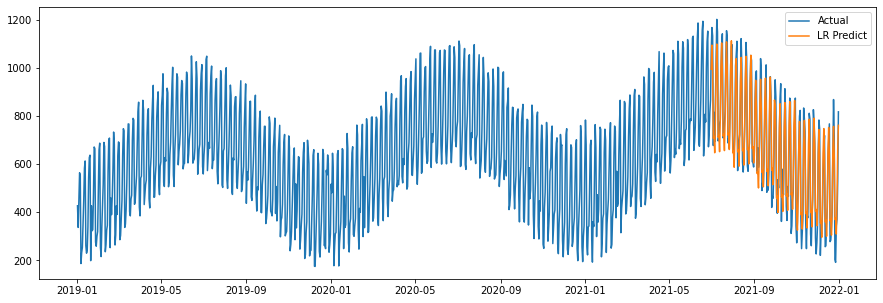

In [69]:
plt.figure(figsize = (15,5))
plt.plot(time_series.item_count, label = "Actual")
plt.plot(test.lr_pred, label = "LR Predict")
plt.legend()
plt.show()

In [70]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [71]:
lr_rmse = mean_squared_error(y_true = test.item_count, y_pred = test.lr_pred, squared = False)
lr_mae = mean_absolute_error(y_true = test.item_count, y_pred = test.lr_pred)
lr_r2_score = r2_score(y_true = test.item_count, y_pred = test.lr_pred)
print("Linear Regression :\nRMSE : {:.2f}\nMAE : {:.2f}\nR2_Score : {:.2f}".format(lr_rmse,lr_mae,lr_r2_score*100))

Linear Regression :
RMSE : 84.84
MAE : 69.63
R2_Score : 88.85


In [72]:
results = pd.DataFrame([lr_rmse, lr_mae,lr_r2_score*100], index = ['RMSE', 'MAE', 'R2_Score'], columns = ['Linear Regression']).round(2)
results

,Linear Regression
RMSE,84.84
MAE,69.63
R2_Score,88.85


### Random Forest

In [73]:
rf = RandomForestRegressor(n_estimators=100, max_depth=20)
rf.fit(X_train, Y_train)

RandomForestRegressor(max_depth=20)

In [74]:
test['rf_pred'] = rf.predict(X_test)

/tmp/ipykernel_269/582745053.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['rf_pred'] = rf.predict(X_test)


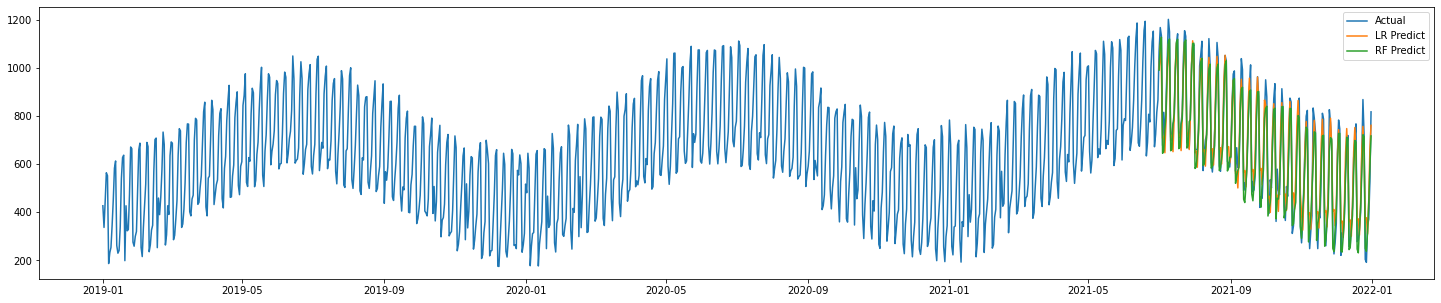

In [75]:
plt.figure(figsize = (25,5))
plt.plot(time_series.item_count, label = "Actual")
plt.plot(test.lr_pred, label = "LR Predict")
plt.plot(test.rf_pred, label = "RF Predict")
plt.legend()
plt.show()

In [76]:
rf_rmse = mean_squared_error(y_true = test.item_count, y_pred = test.rf_pred, squared = False)
rf_mae = mean_absolute_error(y_true = test.item_count, y_pred = test.rf_pred)
rf_r2_score = r2_score(y_true = test.item_count, y_pred = test.rf_pred)
print("Random Forest Regression :\nRMSE : {:.2f}\nMAE : {:.2f}\nR2_Score : {:.2f}".format(rf_rmse,rf_mae,rf_r2_score*100))

Random Forest Regression :
RMSE : 57.66
MAE : 44.54
R2_Score : 94.85


In [77]:
results['Random Forest'] = [rf_rmse,rf_mae,rf_r2_score*100]
results.round(2)

,Linear Regression,Random Forest
RMSE,84.84,57.66
MAE,69.63,44.54
R2_Score,88.85,94.85


### XGBoost

In [78]:
xgb = xgb.XGBRegressor(base_score=0.5, booster='gbtree',
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
xgb.fit(X_train, Y_train,
        eval_set=[(X_train, Y_train), (X_test, Y_test)],
        verbose=100)

/voc/work/.local/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[07:20:20] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[07:20:20] WARNING: ../src/learner.cc:576: 
Parameters: { "early_stopping_rounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-rmse:659.98529	validation_1-rmse:709.35968
[100]	validation_0-rmse:253.88692	validation_1-rmse:314.99744
[200]	validation_0-rmse:110.73307	validation_1-rmse:169.06859
[300]	validation_0-rmse:64.75143	validation_1-rmse:108.17162
[400]	validation_0-rmse:50.15660	validation_1-rmse:82.61115
[500]	validation_0-rmse:44.35604	validation_1-rmse:72.56622
[600]	validation_0-rmse:41.53489	validation_1-rmse:67.21249
[700]	validation_0-rmse:39.94743	validation_1-rmse:64.44896
[800]	validation_0-rmse:

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, early_stopping_rounds=50,
             enable_categorical=False, gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.01, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=8,
             num_parallel_tree=1, objective='reg:linear', predictor='auto',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=None)

According to the output provided, the model is showing signs of overfitting as training progresses:

1. Diverging Training and Validation RMSE: The training RMSE decreases significantly (from 659.98 to 37.00), while the validation RMSE also decreases but at a slower rate (from 709.36 to 60.04), creating a widening gap between the two.

2. Diminishing Returns on Validation RMSE: After a certain point (e.g., iteration 600), the reduction in validation RMSE becomes marginal, suggesting the model is overfitting to the training data.

3. Final Gap in Performance: By iteration 999, the training RMSE is extremely low (37.00), indicating the model has fit the training data almost perfectly, but the higher validation RMSE (60.04) reflects poor generalization to unseen data.

Hyperparameter tuning, such as using RandomizedSearchCV, helps optimize the model by finding the best combination of hyperparameters that balance the trade-off between underfitting and overfitting.

We have covered hyperparameter tuning later in this notebook.

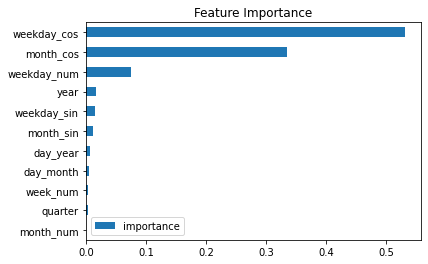

In [80]:
importance = pd.DataFrame(data=xgb.feature_importances_,
             index=xgb.get_booster().feature_names,
             columns=['importance'])
importance.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

In [81]:
test['xgb_pred'] = xgb.predict(X_test)

/voc/work/.local/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/tmp/ipykernel_269/5488039.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['xgb_pred'] = xgb.predict(X_test)


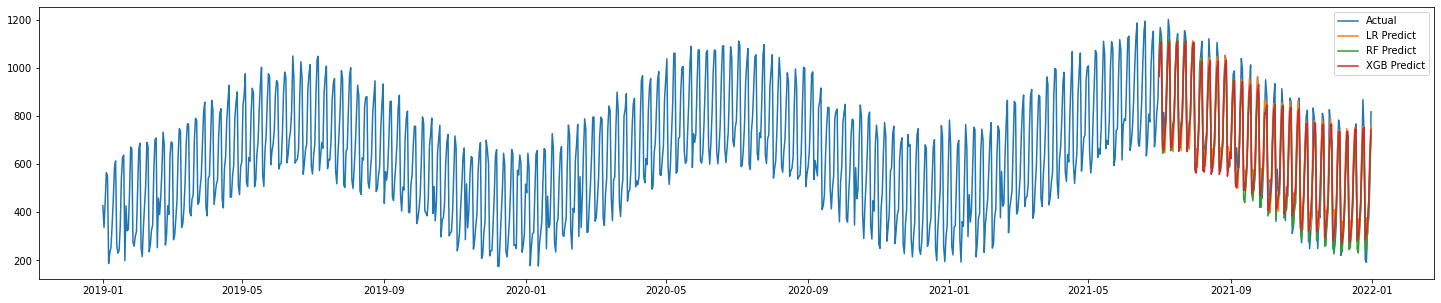

In [82]:
plt.figure(figsize = (25,5))
plt.plot(time_series.item_count, label = "Actual")
plt.plot(test.lr_pred, label = "LR Predict")
plt.plot(test.rf_pred, label = "RF Predict")
plt.plot(test.xgb_pred, label = "XGB Predict")
plt.legend()
plt.show()

In [83]:
xgb_rmse = mean_squared_error(y_true = test.item_count, y_pred = test.xgb_pred, squared = False)
xgb_mae = mean_absolute_error(y_true = test.item_count, y_pred = test.xgb_pred)
xgb_r2_score = r2_score(y_true = test.item_count, y_pred = test.xgb_pred)
print("XGBoost :\nRMSE : {:.2f}\nMAE : {:.2f}\nR2_Score : {:.2f}".format(xgb_rmse,xgb_mae,xgb_r2_score*100))

XGBoost :
RMSE : 60.04
MAE : 47.01
R2_Score : 94.42


In [84]:
results['XGBoost'] = [xgb_rmse,xgb_mae,xgb_r2_score*100]
results = results.round(2)

In [85]:
results

,Linear Regression,Random Forest,XGBoost
RMSE,84.84,57.66,60.04
MAE,69.63,44.54,47.01
R2_Score,88.85,94.85,94.42


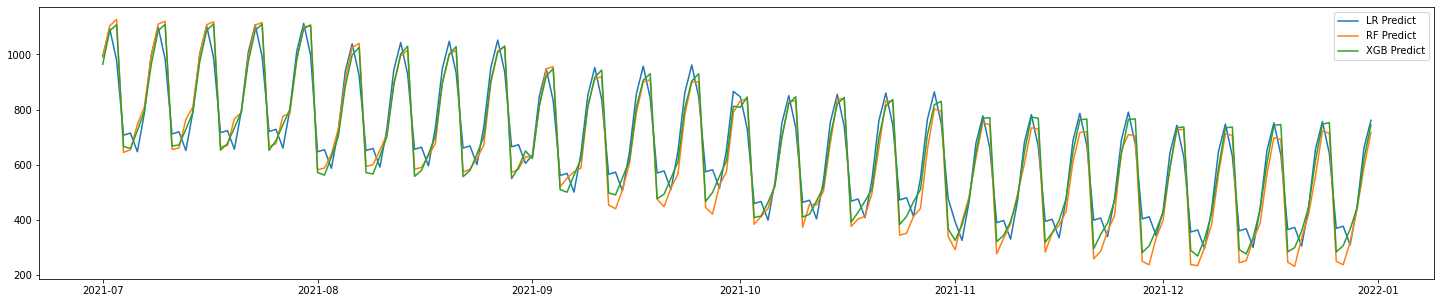

In [86]:
plt.figure(figsize = (25,5))
plt.plot(test.lr_pred, label = "LR Predict")
plt.plot(test.rf_pred, label = "RF Predict")
plt.plot(test.xgb_pred, label = "XGB Predict")
plt.legend()
plt.show()

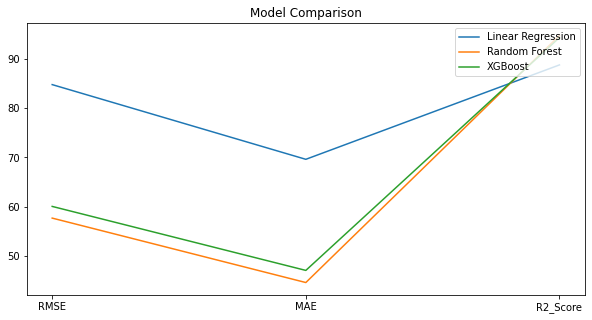

In [87]:
plt.figure(figsize = (10,5))
plt.plot(results['Linear Regression'], label = "Linear Regression")
plt.plot(results['Random Forest'], label = "Random Forest")
plt.plot(results['XGBoost'], label = "XGBoost")
plt.legend(loc = "upper right")
plt.title("Model Comparison")
plt.show()


In [88]:
results

,Linear Regression,Random Forest,XGBoost
RMSE,84.84,57.66,60.04
MAE,69.63,44.54,47.01
R2_Score,88.85,94.85,94.42


Here both Random Forest and XGBoost perform similarly, with XGBoost having a slight edge in accuracy, as indicated by its marginally lower RMSE and MAE, and a slightly higher R² score.

Using it for predictions

## Future Forecating

The primary reason for performing forecasting in this business scenario is to enable informed decision-making and effective resource planning. By accurately predicting the demand for various items across restaurants, Fresh Analytics can help businesses anticipate future sales, optimize inventory levels, and allocate resources (such as staff and production) based on expected demand patterns. Forecasting supports the goal of adapting to competitive market conditions by providing insights into customer demand trends, which is critical for strategic planning at both domestic and international levels. This alignment with the business objective enhances the organization’s ability to meet market needs and achieve operational efficiency.

In [89]:
time_series.index.max()

Timestamp('2021-12-31 00:00:00')

In [90]:
future_predictors = pd.DataFrame(pd.date_range(start="2022-01-01", end="2022-12-31"), columns=['date'])
future_predictors.index = pd.to_datetime(future_predictors.date)


In [91]:
X_train.columns

Index(['quarter', 'year', 'day_year', 'day_month', 'week_num', 'month_num',
       'weekday_num', 'month_sin', 'month_cos', 'weekday_sin', 'weekday_cos'],
      dtype='object')

In [92]:
future_predictors.date.dt.isocalendar().week

date
2022-01-01    52
2022-01-02    52
2022-01-03     1
2022-01-04     1
2022-01-05     1
              ..
2022-12-27    52
2022-12-28    52
2022-12-29    52
2022-12-30    52
2022-12-31    52
Name: week, Length: 365, dtype: UInt32

In [93]:
future_predictors['weekday'] = future_predictors.date.dt.day_name()
future_predictors['quarter'] = future_predictors.date.dt.quarter
future_predictors['year'] = future_predictors.date.dt.year
future_predictors['month_name'] = future_predictors.date.dt.month_name()
future_predictors['day_year'] = future_predictors.date.dt.day_of_year
future_predictors['day_month'] = future_predictors.date.dt.day
future_predictors['week_num'] = future_predictors.date.dt.isocalendar().week


In [94]:
future_predictors.head(5)

,date,weekday,quarter,year,month_name,day_year,day_month,week_num
date,,,,,,,,
2022-01-01,2022-01-01,Saturday,1,2022,January,1,1,52
2022-01-02,2022-01-02,Sunday,1,2022,January,2,2,52
2022-01-03,2022-01-03,Monday,1,2022,January,3,3,1
2022-01-04,2022-01-04,Tuesday,1,2022,January,4,4,1
2022-01-05,2022-01-05,Wednesday,1,2022,January,5,5,1


In [95]:
future_predictors['month_num'] = future_predictors['month_name'].map(month_mapping)
future_predictors['weekday_num'] = future_predictors['weekday'].map(weekday_mapping)

# Apply sine and cosine transformations
future_predictors['month_sin'] = np.sin(2 * np.pi * future_predictors['month_num'] / 12)
future_predictors['month_cos'] = np.cos(2 * np.pi * future_predictors['month_num'] / 12)
future_predictors['weekday_sin'] = np.sin(2 * np.pi * future_predictors['weekday_num'] / 7)
future_predictors['weekday_cos'] = np.cos(2 * np.pi * future_predictors['weekday_num'] / 7)

# Drop the original columns if they are no longer needed
future_predictors = future_predictors.drop(columns=['month_name', 'weekday', 'month_num', 'weekday_num'])

# Display the transformed DataFrame
future_predictors.head()


,date,quarter,year,day_year,day_month,week_num,month_sin,month_cos,weekday_sin,weekday_cos
date,,,,,,,,,,
2022-01-01,2022-01-01,1,2022,1,1,52,0.5,0.866025,-0.974928,-0.222521
2022-01-02,2022-01-02,1,2022,2,2,52,0.5,0.866025,-0.781831,0.623490
2022-01-03,2022-01-03,1,2022,3,3,1,0.5,0.866025,0.000000,1.000000
2022-01-04,2022-01-04,1,2022,4,4,1,0.5,0.866025,0.781831,0.623490
2022-01-05,2022-01-05,1,2022,5,5,1,0.5,0.866025,0.974928,-0.222521


In [96]:
future_predictors['week_num'] = future_predictors['week_num'].astype(int)

In [97]:
# Ensure future_predictors has the same columns as X_train after transformations
future_predictors = future_predictors.reindex(columns=X_train.columns)

# Use the model for prediction
future_predictors['predictions'] = xgb.predict(future_predictors)


/voc/work/.local/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


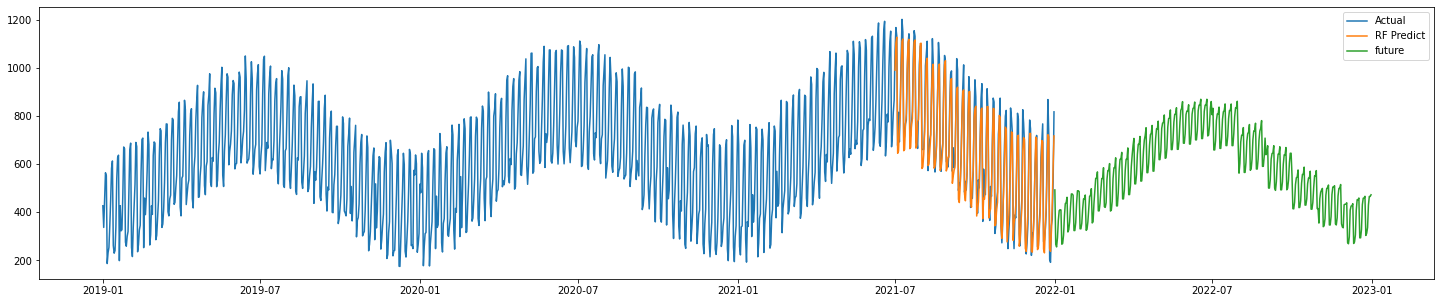

In [98]:
plt.figure(figsize = (25,5))
plt.plot(time_series.item_count, label = "Actual")
plt.plot(test.rf_pred, label = "RF Predict")
plt.plot(future_predictors.predictions, label = "future")
plt.legend()
plt.show()

## Backtesting for forecasting

To perform backtesting for forecasting, you can use a rolling or expanding window approach to simulate how your model would perform over time. In this example, we'll use a rolling window approach, where we train the model on a subset of the data, make predictions for the next period, then expand the training set by including the predicted period, and repeat. This gives a realistic view of model performance over time.

In [99]:
# Define backtesting parameters
train_size = int(len(time_series) * 0.8)  # Use 80% of data for initial training
test_size = len(time_series) - train_size
rolling_window = 12  # Define the rolling window size (e.g., 12 months if monthly data)


In [100]:
# Initialize lists to store evaluation metrics
rmse_scores = []
mae_scores = []
r2_scores = []

In [101]:
# Train-test split
train = time_series.iloc[:train_size]
test = time_series.iloc[train_size:]

# Separate features and target
X_train = train.drop(columns=['item_count'])  # Drop the target column for training features
Y_train = train['item_count']                # Target column for training labels

X_test = test.drop(columns=['item_count'])   # Drop the target column for testing features
Y_test = test['item_count']                  # Target column for testing labels


In [104]:
test_features = X_test.reindex(columns=X_train.columns)

In [105]:
from matplotlib.animation import FuncAnimation

In [106]:
test_features = test_features.reindex(columns=X_train.columns)

In [108]:
%matplotlib notebook
# Train the model once
model = XGBRegressor(n_estimators=100)
model.fit(X_train, Y_train)

# Prepare predictions list
predictions = []
dates = []

for i in range(len(test_features)):
    X_test = test_features.iloc[i:i+1]
    pred = model.predict(X_test)[0]
    predictions.append(pred)
    dates.append(test.index[i])


# Set up the figure and axis for the animation
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(time_series.index, time_series['item_count'], label="Actual", color='black')
line, = ax.plot([], [], label="Predictions", color='blue', linestyle='--')
ax.set_xlim(time_series.index[0], test.index[-1])
ax.set_ylim(min(time_series['item_count']), max(time_series['item_count']))
ax.set_title("Animated Sequential Forecasting without Model Refit")
ax.set_xlabel("Date")
ax.set_ylabel("Item Count")
ax.legend()

# Initialize function
def init():
    line.set_data([], [])
    return line,

# Update function for animation
def update(frame):
    line.set_data(dates[:frame], predictions[:frame])
    return line,

# Run the animation
ani = FuncAnimation(fig, update, frames=len(dates), init_func=init, blit=True, repeat=False)

# Display the animation
plt.show()

ani.save('backtesting_animation.gif', writer='imagemagick', fps=10)


/voc/work/.local/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


<IPython.core.display.Javascript object>

MovieWriter imagemagick unavailable; using Pillow instead.


## Hypertuning XGBoost with RandomizedSearchCV

This guide demonstrates how to use RandomizedSearchCV to tune the hyperparameters of an XGBoost model. Randomized search is efficient for exploring large hyperparameter spaces as it randomly samples a subset of possible combinations.

#### Key Hyperparameters to Tune
`learning_rate`: Controls the step size at each iteration. Common values are between 0.01 and 0.3.

`n_estimators`: Number of boosting rounds (trees) to build. A higher value can improve performance but may lead to overfitting.

`max_depth`: Maximum depth of each tree. Higher values allow capturing more complex patterns, but too high may lead to overfitting.

`subsample`: Fraction of samples used per tree. Values between 0.5 and 1.0 are typical.

`colsample_bytree`: Fraction of features considered per tree. Values between 0.5 and 1.0 are commonly used.

`alpha and lambda`: L1 and L2 regularization parameters to control overfitting.

### Code implementation

```python
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

# Define the parameter grid for randomized search
param_dist = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'n_estimators': [100, 300, 500, 700],
    'max_depth': [3, 5, 7, 9],
    'subsample': [0.6, 0.7, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 1.0],
    'alpha': [0, 0.1, 1, 10],
    'lambda': [1, 1.5, 2, 5]
}

# Initialize the XGBoost model
xgb = XGBRegressor()

# Set up RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=50,  # Number of parameter settings sampled
    cv=3,  # 3-fold cross-validation
    scoring='neg_mean_squared_error',
    verbose=1,
    n_jobs=-1,
    random_state=42
)

# Fit the randomized search on the training data
random_search.fit(X_train, Y_train)

# Get the best parameters and corresponding RMSE score
best_params = random_search.best_params_
best_rmse = np.sqrt(-random_search.best_score_)

print("Best parameters found: ", best_params)
print("Best RMSE: ", best_rmse)

# Train the model with the best parameters
xgb_best = XGBRegressor(**best_params)
xgb_best.fit(X_train, Y_train)

# Evaluate the model on the validation/test set
val_predictions = xgb_best.predict(X_val)
val_rmse = np.sqrt(mean_squared_error(Y_val, val_predictions))
print("Validation RMSE with tuned model: ", val_rmse)


```